---

# Georgios_Ioannou


## Copyright © 2023 by Georgios Ioannou


---

<h1 align="center"> Text Emotion System Sentiment Analysis </h1>
<h2 align="center"> TESSA </h2>

In this notebook, we will be classifying emotion based on text documents. The dataset we will be using is called:

<p style="text-align: center;"><a href="https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp">Emotions Dataset for NLP</a></p>


---

<h2 align="center"> Remember our main steps motto "ISBE" </h2>

<h3 align="center"> Main Steps when building a Machine Learning Model </h3>

1. **I** - `Inspect and explore data`
2. **S** - `Select and engineer features`
3. **B** - `Build and train model`
4. **E** - `Evaluate model`


---

<h2 align='center'> GPU Information </h2>


In [1]:
!nvidia-smi

Wed Dec 20 04:07:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---

<h2 align='center'> Libraries </h2>


In [3]:
# Import libraries.

# Use inline so our visualizations display in notebook.


%matplotlib inline


import matplotlib.pyplot as plt   # Data visualization.
import nltk                       # Natural Language Processing.
import numpy as np                # Data wrangling.
import os                         # Manipulate operating system interfaces.
import pandas as pd               # Data handling.
pd.set_option('display.max_colwidth', None)
import pickle                     # Python object serialization.
import plotly.express as px       # Data visualization
import plotly.graph_objects as go # Data visualization
import re                         # Regular expression operations.
import seaborn as sns             # Data visualization.
import subprocess                 # To download nltk wordnet in Kaggle.
sns.set()
import warnings                   # Ignore all warnings.
warnings.filterwarnings('ignore')


from nltk.stem import WordNetLemmatizer # Lemmatize using WordNet's built-in morphy function.
from nltk.stem import                   # Remove morphological affixes from words, leaving only the word stem.
from nltk.corpus import stopwords       # Remove stopwaords.
from nltk import word_tokenize          # Tokenize.
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, multilabel_confusion_matrix, precision_score, recall_score # Evaluation metrics.
from sklearn.model_selection import train_test_split     # Eplit data in training/validating/testing.
from sklearn.preprocessing import LabelEncoder           # Encode target labels with value between 0 and n_classes-1.
from tensorflow.keras.callbacks import EarlyStopping     # Stop training when a monitored metric has stopped improving.
from tensorflow.keras.callbacks import ReduceLROnPlateau # Reduce learning rate when a metric has stopped improving.
from tensorflow.keras.layers import Activation, Conv1D, Dense, Dropout, Embedding, LSTM, MaxPooling1D # Keras layers API.
from tensorflow.keras.models import Sequential # Sequential model.
from tensorflow.keras.optimizers import Adam   # Adam optimizer.
from tensorflow.keras.preprocessing.sequence import pad_sequences # Transformsa list of sequences into a 2D Numpy array.
from tensorflow.keras.preprocessing.text import Tokenizer         # Vectorize a text corpus.
from tensorflow.keras.utils import plot_model                     # Visualize the model and save it.
from tensorflow.keras.utils import to_categorical                 # Converts a class vector (integers) to binary class matrix.

try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')
from nltk.corpus import wordnet

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


True

---

## #1 Inspect And Explore Data


## 1.1 List All Files Under The Input Directory To See The Number Of Files


In [4]:
files_list = []
files_count = 0

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        files_list.append(os.path.join(dirname, filename))
        files_count += 1

print("\nLength of files_list =", len(files_list), end="\n\n")
print("files_list[0] =", files_list[0])
print("files_list[1] =", files_list[1])
print("files_list[2] =", files_list[2])


Length of files_list = 3

files_list[0] = /kaggle/input/emotions-dataset-for-nlp/val.txt
files_list[1] = /kaggle/input/emotions-dataset-for-nlp/test.txt
files_list[2] = /kaggle/input/emotions-dataset-for-nlp/train.txt


## 1.2 Import Dataset Paths


In [5]:
EMOTIONS_DATASET_FOR_NLP_TRAIN_PATH = "../input/emotions-dataset-for-nlp/train.txt"
EMOTIONS_DATASET_FOR_NLP_VAL_PATH = "../input/emotions-dataset-for-nlp/val.txt"
EMOTIONS_DATASET_FOR_NLP_TEST_PATH = "../input/emotions-dataset-for-nlp/test.txt"

## 1.3 Explore the Data of the [`Emotions Dataset for NLP`](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp)


### 1.3.1 Read the Text Files


In [6]:
# Open the train.txt file in read mode.

with open(EMOTIONS_DATASET_FOR_NLP_TRAIN_PATH, "r") as train_file:
    head = [next(train_file) for i in range(1)]

# Print the first line of the train.txt file.

print(head, "\n")


# Open the train.txt file in read mode.

with open(EMOTIONS_DATASET_FOR_NLP_TRAIN_PATH, "r") as train_file:
    head = [next(train_file) for i in range(5)]

# Print the first five lines of the train.txt file.

print(head)

['i didnt feel humiliated;sadness\n'] 

['i didnt feel humiliated;sadness\n', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake;sadness\n', 'im grabbing a minute to post i feel greedy wrong;anger\n', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property;love\n', 'i am feeling grouchy;anger\n']


In [7]:
# Open the val.txt file in read mode.

with open(EMOTIONS_DATASET_FOR_NLP_VAL_PATH, "r") as train_file:
    head = [next(train_file) for i in range(1)]

# Print the first line of the val.txt file.

print(head, "\n")


# Open the val.txt file in read mode.

with open(EMOTIONS_DATASET_FOR_NLP_VAL_PATH, "r") as train_file:
    head = [next(train_file) for i in range(5)]

# Print the first five lines of the val.txt file.

print(head)

['im feeling quite sad and sorry for myself but ill snap out of it soon;sadness\n'] 

['im feeling quite sad and sorry for myself but ill snap out of it soon;sadness\n', 'i feel like i am still looking at a blank canvas blank pieces of paper;sadness\n', 'i feel like a faithful servant;love\n', 'i am just feeling cranky and blue;anger\n', 'i can have for a treat or if i am feeling festive;joy\n']


In [8]:
# Open the test.txt file in read mode.

with open(EMOTIONS_DATASET_FOR_NLP_TEST_PATH, "r") as train_file:
    head = [next(train_file) for i in range(1)]

# Print the first line of the test.txt file.

print(head, "\n")


# Open the test.txt file in read mode.

with open(EMOTIONS_DATASET_FOR_NLP_TEST_PATH, "r") as train_file:
    head = [next(train_file) for i in range(5)]

# Print the first five lines of the test.txt file.

print(head)

['im feeling rather rotten so im not very ambitious right now;sadness\n'] 

['im feeling rather rotten so im not very ambitious right now;sadness\n', 'im updating my blog because i feel shitty;sadness\n', 'i never make her separate from me because i don t ever want her to feel like i m ashamed with her;sadness\n', 'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived;joy\n', 'i was feeling a little vain when i did this one;sadness\n']


### 1.3.2 Convert Text Files To Pandas Dataframes For Data Handling, Data Wrangling, and Explanatory Data Analysis


In [9]:
# Train Pandas Dataframe.

train_df = pd.read_csv(
    filepath_or_buffer=EMOTIONS_DATASET_FOR_NLP_TRAIN_PATH,
    sep=";",
    names=["document", "emotion"],
)

# Validation Pandas Dataframe.

val_df = pd.read_csv(
    filepath_or_buffer=EMOTIONS_DATASET_FOR_NLP_VAL_PATH,
    sep=";",
    names=["document", "emotion"],
)

# Test Pandas Dataframe.

test_df = pd.read_csv(
    filepath_or_buffer=EMOTIONS_DATASET_FOR_NLP_TEST_PATH,
    sep=";",
    names=["document", "emotion"],
)

### 1.3.3 Explore The Data Of Train, Validation, and Test


Sanity Check
------------
train_df.shape = (16000, 2) 

****************************************************************************************************
Null Values Per Column
----------------------
train_df.isnull().sum() =
document    0
emotion     0
dtype: int64 

Null Values In The Whole Train Pandas Dataframe
----------------------------------------------
train_df.isnull().sum().sum() =  0 

****************************************************************************************************
Duplicate Rows
--------------
duplicates.sum() = 1
Duplicate Rows   =                                                             document emotion
13846  i feel more adventurous willing to take risks img src http cdn     joy

train_df.shape = (15999, 2) 

****************************************************************************************************
Duplicate Documents
-------------------
len(train_df[duplicates]) = 30
                                                                   

,document,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag and i said to anna that i feel like i have been beaten up,sadness
15996,i am now turning and i feel pathetic that i am still waiting tables and subbing with a teaching degree,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and im glad that t,anger


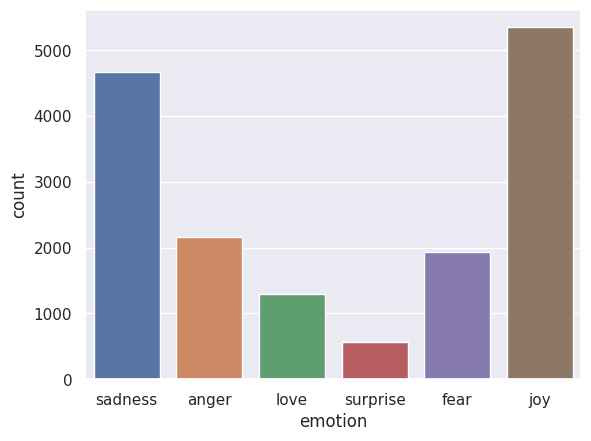

In [10]:
# Train Pandas Dataframe.

# Sanity check.

print("Sanity Check")
print("------------")

print("train_df.shape =", train_df.shape, "\n")

print("*" * 100)

# Check for null values per column.

print("Null Values Per Column")
print("----------------------")

print("train_df.isnull().sum() =")
print(train_df.isnull().sum(), "\n")

# Check for null values in the whole train Pandas dataframe.

print("Null Values In The Whole Train Pandas Dataframe")
print("----------------------------------------------")

print("train_df.isnull().sum().sum() = ", train_df.isnull().sum().sum(), "\n")

print("*" * 100)

# Check for duplicate rows in the train Pandas dataframe.

print("Duplicate Rows")
print("--------------")

duplicates = train_df.duplicated()
print("duplicates.sum() =", duplicates.sum())
print("Duplicate Rows   =", end="")
print(train_df[duplicates])

# Drop duplicate rows.

train_df = train_df.drop_duplicates()

# Sanity check.

print("\ntrain_df.shape =", train_df.shape, "\n")

print("*" * 100)

# Check for duplicate documents in the train Pandas dataframe.
# (i.e. Documents that have more than one emotion attached to them.)
# Each document must have one and only one emotion.
# Keep only th first occurence of such a document.

print("Duplicate Documents")
print("-------------------")

# Check for duplicate entries in the 'document' column of the
# train Pandas dataframe and returns a boolean Series.
# The boolean Series is stored in the 'duplicates' variable.

duplicates = train_df.duplicated(subset="document")

# Print the length of the 'duplicates' boolean Series,
# which represents the number of duplicate 'document' entries.

print("len(train_df[duplicates]) =", len(train_df[duplicates]))

# Print the rows of the train Pandas dataframe where the 'document' entry is a duplicate.

print(train_df[duplicates])

# Remove the duplicate entries from the train Pandas dataframe.
# The 'subset' parameter is used to specify the column to check for duplicates.

train_df = train_df.drop_duplicates(subset="document")

# Sanity check.

print("\ntrain_df.shape =", train_df.shape, "\n")

print("*" * 100)

# Display the six unique emotions sorted in ascending order.

print("Classes and Value Counts")
print("------------------------")

print("Unique emotions =", sorted(train_df["emotion"].unique()), "\n")
print("# of Unique emotions =", len(train_df["emotion"].unique()), "\n")

# Display the value count for each emotion.

print(train_df.emotion.value_counts(), "\n")

print("*" * 100)

# This is the indexing that will be used for Label Encoding at a later stage.

print("Label Encoding")
print("--------------")

print("0=anger, 1=fear, 2=joy, 3=love, 4=sadness, 5=surprise\n")

print("*" * 100)

# Create a count plot for the train Pandas dataframe.

sns.countplot(data=train_df, x="emotion")

train_df

Sanity Check
------------
val_df.shape = (2000, 2) 

****************************************************************************************************
Null Values Per Column
----------------------
val_df.isnull().sum() =
document    0
emotion     0
dtype: int64 

Null Values In The Whole Validation Pandas Dataframe
----------------------------------------------------
val_df.isnull().sum().sum() =  0 

****************************************************************************************************
Duplicate Rows
--------------
duplicates.sum() = 0
Duplicate Rows   =Empty DataFrame
Columns: [document, emotion]
Index: []

val_df_df.shape = (2000, 2) 

****************************************************************************************************
Duplicate Documents
-------------------
len(val_df[duplicates]) = 2
                                                                                                                                           document  \
603   i have had

,document,emotion
0,im feeling quite sad and sorry for myself but ill snap out of it soon,sadness
1,i feel like i am still looking at a blank canvas blank pieces of paper,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy
...,...,...
1995,im having ssa examination tomorrow in the morning im quite well prepared for the coming exam and somehow i feel numb towards exam because in life there is much more important things than exam,sadness
1996,i constantly worry about their fight against nature as they push the limits of their inner bodies for the determination of their outer existence but i somehow feel reassured,joy
1997,i feel its important to share this info for those that experience the same thing,joy
1998,i truly feel that if you are passionate enough about something and stay true to yourself you will succeed,joy


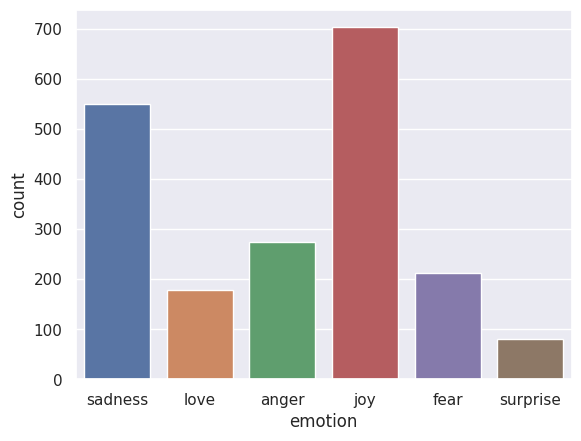

In [11]:
# Validation Pandas Dataframe.

# Sanity check.

print("Sanity Check")
print("------------")

print("val_df.shape =", val_df.shape, "\n")

print("*" * 100)

# Check for null values per column.

print("Null Values Per Column")
print("----------------------")

print("val_df.isnull().sum() =")
print(val_df.isnull().sum(), "\n")

# Check for null values in the whole validation Pandas dataframe.

print("Null Values In The Whole Validation Pandas Dataframe")
print("----------------------------------------------------")

print("val_df.isnull().sum().sum() = ", val_df.isnull().sum().sum(), "\n")

print("*" * 100)

# Check for duplicate rows in the train Pandas dataframe.

print("Duplicate Rows")
print("--------------")

duplicates = val_df.duplicated()
print("duplicates.sum() =", duplicates.sum())
print("Duplicate Rows   =", end="")
print(val_df[duplicates])

# Drop duplicate rows.

val_df = val_df.drop_duplicates()

# Sanity check.

print("\nval_df_df.shape =", val_df.shape, "\n")

print("*" * 100)

# Check for duplicate documents in the validation Pandas dataframe.
# (i.e. Documents that have more than one emotion attached to them.)
# Each document must have one and only one emotion.

# Check for duplicate entries in the 'document' column of the
# validation Pandas dataframe and returns a boolean Series.
# The boolean Series is stored in the 'duplicates' variable.
# Keep only th first occurence of such a document.

print("Duplicate Documents")
print("-------------------")

duplicates = val_df.duplicated(subset="document")

# Print the length of the 'duplicates' boolean Series,
# which represents the number of duplicate 'document' entries.

print("len(val_df[duplicates]) =", len(val_df[duplicates]))

# Print the rows of the validation Pandas dataframe where the 'document' entry is a duplicate.

print(val_df[duplicates])

# Remove the duplicate entries from the validation Pandas dataframe.
# The 'subset' parameter is used to specify the column to check for duplicates.

val_df = val_df.drop_duplicates(subset="document")

# Sanity check.

print("\nval_df.shape =", val_df.shape, "\n")

print("*" * 100)

# Display the six unique emotions sorted in ascending order.

print("Classes and Value Counts")
print("------------------------")

print("Unique emotions =", sorted(val_df["emotion"].unique()), "\n")
print("# of Unique emotions =", len(val_df["emotion"].unique()), "\n")

# Display the value count for each emotion.

print(val_df.emotion.value_counts(), "\n")

print("*" * 100)

# This is the indexing that will be used for Label Encoding at a later stage.

print("Label Encoding")
print("--------------")

print("0=anger, 1=fear, 2=joy, 3=love, 4=sadness, 5=surprise\n")

print("*" * 100)

# Create a count plot for the validation Pandas dataframe.

sns.countplot(data=val_df, x="emotion")

val_df

Sanity Check
------------
test_df.shape = (2000, 2) 

****************************************************************************************************
Null Values Per Column
----------------------
test_df.isnull().sum() =
document    0
emotion     0
dtype: int64 

Null Values In The Whole Test Pandas Dataframe
----------------------------------------------
test_df.isnull().sum().sum() =  0 

****************************************************************************************************
Duplicate Rows
--------------
duplicates.sum() = 0
Duplicate Rows   =Empty DataFrame
Columns: [document, emotion]
Index: []

test_df.shape = (2000, 2) 

****************************************************************************************************
Duplicate Documents
-------------------
len(test_df[duplicates]) = 0
Empty DataFrame
Columns: [document, emotion]
Index: []

test_df.shape = (2000, 2) 

*********************************************************************************************

,document,emotion
0,im feeling rather rotten so im not very ambitious right now,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i don t ever want her to feel like i m ashamed with her,sadness
3,i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
1995,i just keep feeling like someone is being unkind to me and doing me wrong and then all i can think of doing is to get back at them and the people they are close to,anger
1996,im feeling a little cranky negative after this doctors appointment,anger
1997,i feel that i am useful to my people and that gives me a great feeling of achievement,joy
1998,im feeling more comfortable with derby i feel as though i can start to step out my shell,joy


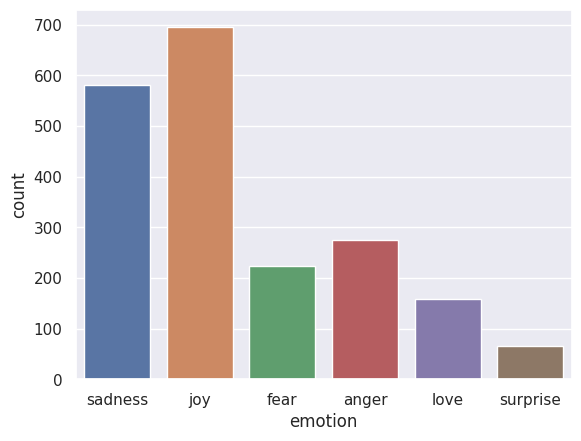

In [12]:
# Test Pandas Dataframe.

# Sanity check.

print("Sanity Check")
print("------------")

print("test_df.shape =", test_df.shape, "\n")

print("*" * 100)

# Check for null values per column.

print("Null Values Per Column")
print("----------------------")

print("test_df.isnull().sum() =")
print(test_df.isnull().sum(), "\n")

# Check for null values in the whole test Pandas dataframe.

print("Null Values In The Whole Test Pandas Dataframe")
print("----------------------------------------------")

print("test_df.isnull().sum().sum() = ", test_df.isnull().sum().sum(), "\n")

print("*" * 100)

# Check for duplicate rows in the test Pandas dataframe.

print("Duplicate Rows")
print("--------------")

duplicates = test_df.duplicated()
print("duplicates.sum() =", duplicates.sum())
print("Duplicate Rows   =", end="")
print(test_df[duplicates])

# Drop duplicate rows.

test_df = test_df.drop_duplicates()

# Sanity check.

print("\ntest_df.shape =", test_df.shape, "\n")

print("*" * 100)

# Check for duplicate documents in the test Pandas dataframe.
# (i.e. Documents that have more than one emotion attached to them.)
# Each document must have one and only one emotion.
# Keep only th first occurence of such a document.

# Check for duplicate entries in the 'document' column of the
# test Pandas dataframe and returns a boolean Series.
# The boolean Series is stored in the 'duplicates' variable.

print("Duplicate Documents")
print("-------------------")

duplicates = test_df.duplicated(subset="document")

# Print the length of the 'duplicates' boolean Series,
# which represents the number of duplicate 'document' entries.

print("len(test_df[duplicates]) =", len(test_df[duplicates]))

# Print the rows of the test Pandas dataframe where the 'document' entry is a duplicate.

print(test_df[duplicates])

# Remove the duplicate entries from the test Pandas dataframe.
# The 'subset' parameter is used to specify the column to check for duplicates.

test_df = test_df.drop_duplicates(subset="document")

# Sanity check.

print("\ntest_df.shape =", test_df.shape, "\n")

print("*" * 100)

# Display the six unique emotions sorted in ascending order.

print("Classes and Value Counts")
print("------------------------")

print("Unique emotions =", sorted(test_df["emotion"].unique()), "\n")
print("# of Unique emotions =", len(test_df["emotion"].unique()), "\n")

# Display the value count for each emotion.

print(test_df.emotion.value_counts(), "\n")

print("*" * 100)

# This is the indexing that will be used for Label Encoding at a later stage.

print("Label Encoding")
print("--------------")

print("0=anger, 1=fear, 2=joy, 3=love, 4=sadness, 5=surprise\n")

print("*" * 100)

# Create a count plot for the test Pandas dataframe.

sns.countplot(data=test_df, x="emotion")

test_df

### 1.3.4 Merge All Three Dataframes To One Dataframe


In [13]:
# Combined Pandas Dataframe.

combined_df = pd.concat(
    [
        train_df,
        val_df,
        test_df,
    ],
    axis=0,
)

# Sanity check.

print("Sanity Check")
print("------------")

print("combined_df.shape =", combined_df.shape, "\n")

print("*" * 100)

# Check for null values per column.

print("Null Values Per Column")
print("----------------------")

print("combined_df.isnull().sum() =")
print(combined_df.isnull().sum(), "\n")

# Check for null values in the whole combined Pandas dataframe.

print("Null Values In The Whole Combined Pandas Dataframe")
print("--------------------------------------------------")

print("combined_df.isnull().sum().sum() = ", combined_df.isnull().sum().sum(), "\n")

print("*" * 100)

# Check for duplicate rows in the combined Pandas dataframe.

print("Duplicate Rows")
print("--------------")

duplicates = combined_df.duplicated()
print("duplicates.sum() =", duplicates.sum())
print("Duplicate Rows   =", end="")
print(combined_df[duplicates])

# Drop duplicate rows.

combined_df = combined_df.drop_duplicates()

# Sanity check.

print("\combined_df.shape =", combined_df.shape, "\n")

print("*" * 100)

# Check for duplicate documents in the combined Pandas dataframe.
# (i.e. Documents that have more than one emotion attached to them.)
# Each document must have one and only one emotion.
# Keep only th first occurence of such a document.

# Check for duplicate entries in the 'document' column of the
# combined Pandas dataframe and returns a boolean Series.
# The boolean Series is stored in the 'duplicates' variable.

print("Duplicate Documents")
print("-------------------")

duplicates = combined_df.duplicated(subset="document")

# Print the length of the 'duplicates' boolean Series,
# which represents the number of duplicate 'document' entries.

print("len(combined_df[duplicates]) =", len(combined_df[duplicates]))

# Print the rows of the combined Pandas dataframe where the 'document' entry is a duplicate.

print(combined_df[duplicates])

# Remove the duplicate entries from the combined Pandas dataframe.
# The 'subset' parameter is used to specify the column to check for duplicates.

combined_df = combined_df.drop_duplicates(subset="document")

# Sanity check.

print("\ncombined_df.shape =", combined_df.shape, "\n")

print("*" * 100)

# Display the six unique emotions sorted in ascending order.

print("Classes and Value Counts")
print("------------------------")

print("Unique emotions =", sorted(combined_df["emotion"].unique()), "\n")
print("# of Unique emotions =", len(combined_df["emotion"].unique()), "\n")
print("# of Unique documents = ", len(combined_df["document"].unique()), "\n")

# Display the value count for each emotion.

print(combined_df.emotion.value_counts(), "\n")

print(
    combined_df.emotion.value_counts(), combined_df.emotion.value_counts(normalize=True)
)
print("*" * 100)

# This is the indexing that will be used for Label Encoding at a later stage.

print("Label Encoding")
print("--------------")

print("0=anger, 1=fear, 2=joy, 3=love, 4=sadness, 5=surprise\n")

print("*" * 100)

combined_df

Sanity Check
------------
combined_df.shape = (19967, 2) 

****************************************************************************************************
Null Values Per Column
----------------------
combined_df.isnull().sum() =
document    0
emotion     0
dtype: int64 

Null Values In The Whole Combined Pandas Dataframe
--------------------------------------------------
combined_df.isnull().sum().sum() =  0 

****************************************************************************************************
Duplicate Rows
--------------
duplicates.sum() = 0
Duplicate Rows   =Empty DataFrame
Columns: [document, emotion]
Index: []
\combined_df.shape = (19967, 2) 

****************************************************************************************************
Duplicate Documents
-------------------
len(combined_df[duplicates]) = 19
                                                                                                                                                  

,document,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,love
4,i am feeling grouchy,anger
...,...,...
1995,i just keep feeling like someone is being unkind to me and doing me wrong and then all i can think of doing is to get back at them and the people they are close to,anger
1996,im feeling a little cranky negative after this doctors appointment,anger
1997,i feel that i am useful to my people and that gives me a great feeling of achievement,joy
1998,im feeling more comfortable with derby i feel as though i can start to step out my shell,joy


#### 1.3.4.1 Display A Document For Each And Every Emotion


In [14]:
# Group the combined_df Pandas dataframe by 'emotion'.

grouped_df = combined_df.groupby("emotion")

# For each group, randomly select one document.

sampled_df = grouped_df.sample(n=1)

# Display the sampled dataframe.

sampled_df

,document,emotion
1339,i have rarely left a meeting feeling more angry and upset,anger
477,i feel so helpless knowing i cant protect them and i worry about the others now,fear
481,i love sliding down on a nice big throbbing cock and feeling what my gorgeous body does to a man,joy
15525,i sense and keeps catching my attention is the feeling of the beloved s love pouring out of and through me touching those i encounter in a palpably strong way,love
8846,i feel so weepy like any moment i could just burst into tears,sadness
9609,i found the art at the other side of all i feel very impressed with my work,surprise


#### 1.3.4.2 Bar Chart And Pie Chart Of The Unique Emotions


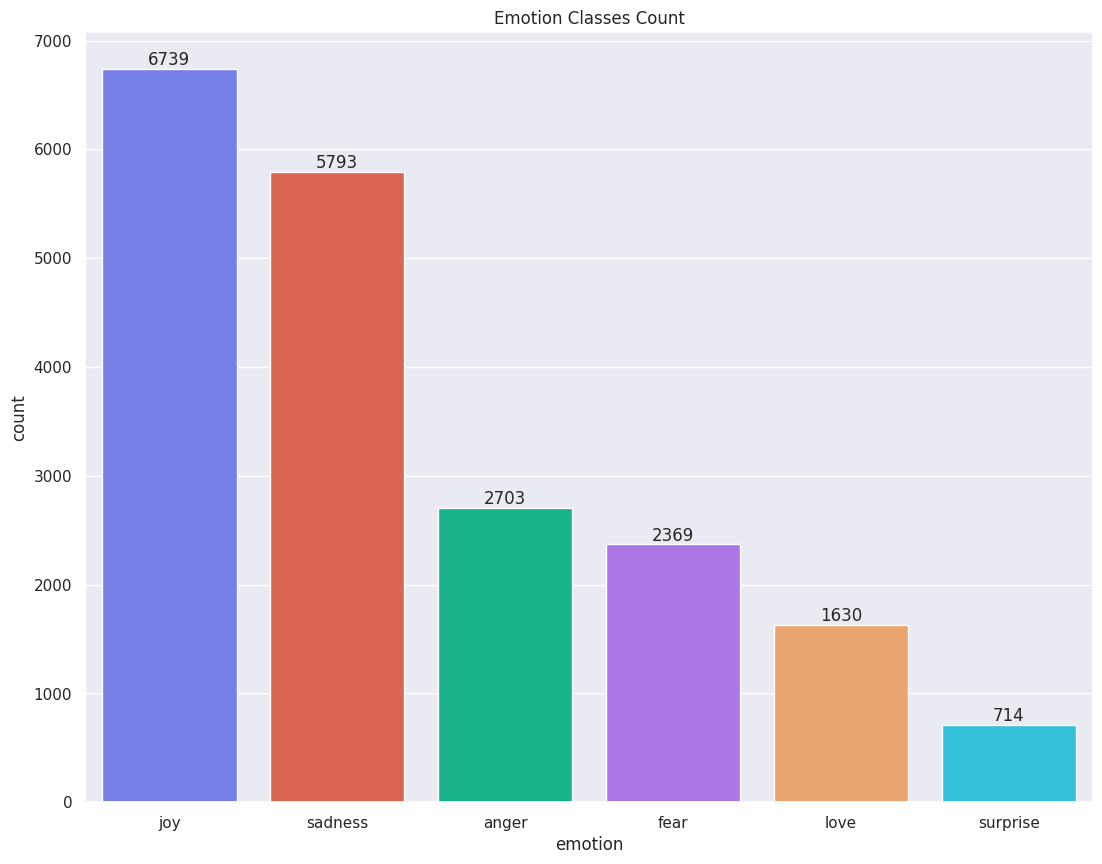

In [15]:
# Set the size of the figure to be 13x10.

plt.figure(figsize=(13, 10))

# Set the title of the figure to be 'Emotion Classes Count'.

plt.title("Emotion Classes Count")

# Create a count plot of the 'emotion' column in the combined Pandas dataframe.
# The 'order' parameter is used to specify the order of the bars.
# The bars are ordered based on the index of the 'emotion' column's value counts.
# The 'palette' parameter is used to specify the colors of the bars.

ax = sns.countplot(
    data=combined_df,
    x="emotion",
    order=combined_df["emotion"].value_counts().index,
    palette=["#636efa", "#ef553b", "#00cc96", "#ab63fa", "#ffa15a", "#19d3f3"],
)

# Add labels to the bars in the plot. The labels are the counts of each emotion.

ax.bar_label(ax.containers[0])

# Display the figure.

plt.show()

In [16]:
# Create a new Pandas dataframe that contains the 'emotion' column and its corresponding counts.
# The 'reset_index()' function is used to reset the index of the Pandas dataframe.
# The result is then stored in the 'emotion_counts' variable.

emotion_counts = combined_df["emotion"].value_counts().reset_index()

# Rename the columns of the emotion_counts Pandas dataframe to 'emotion' and 'count'.

emotion_counts.columns = ["emotion", "count"]

# Create a count plot of the emotion_counts Pandas dataframe.
# The 'x'      parameter is used to specify the column to plot on the x-axis, which is 'emotion'.
# The 'y'      parameter is used to specify the column to plot on the y-axis, which is 'count'.
# The 'color'  parameter is used to specify the column to use for the color of the bars, which is 'emotion'.
# The 'labels' parameter is used to specify the labels for the x-axis and y-axis.
# The 'title'  parameter is used to specify the title of the plot.

fig = px.bar(
    data_frame=emotion_counts,
    x="emotion",
    y="count",
    color="emotion",
    labels={"x": "emotion", "y": "count"},
    title="Emotion Classes Count",
)

# Displays the figure.

fig.show()

In [17]:
# Get the count of unique values in the 'emotion' column of the combined_df Pandas dataframe.

combined_df["emotion"].value_counts()

# Get the index of the value counts, which are the unique emotion values.

labels = combined_df["emotion"].value_counts().index

# Get` the values of the value counts, which are the counts of each emotion.

values = combined_df["emotion"].value_counts().values

# Define a list of colors to be used for the pie chart.

colors = [
    "#636efa",
    "#ef553b",
    "#00cc96",
    "#ab63fa",
    "#ffa15a",
    "#19d3f3",
    "#ff6692",
    "#b5e87f",
]

# Create a pie chart using the 'labels', 'values', and 'colors'.
# The 'textinfo'               parameter is set to 'label+percent' to display the labels and the percentage of each slice in the pie chart.
# The 'insidetextorientation' parameter is set to 'radial' to orient the labels radially.
# The 'marker'                parameter is used to set the colors of the slices.

fig = go.Figure(
    data=[
        go.Pie(
            labels=labels,
            values=values,
            textinfo="label+percent",
            insidetextorientation="radial",
            marker=dict(colors=colors),
        )
    ]
)

# Set the title of the pie chart.

fig.update_layout(title="Emotion Classes Counts")

# Display the figure.

fig.show()

#### 1.3.4.3 Visualize Document Length (KDE Plot)


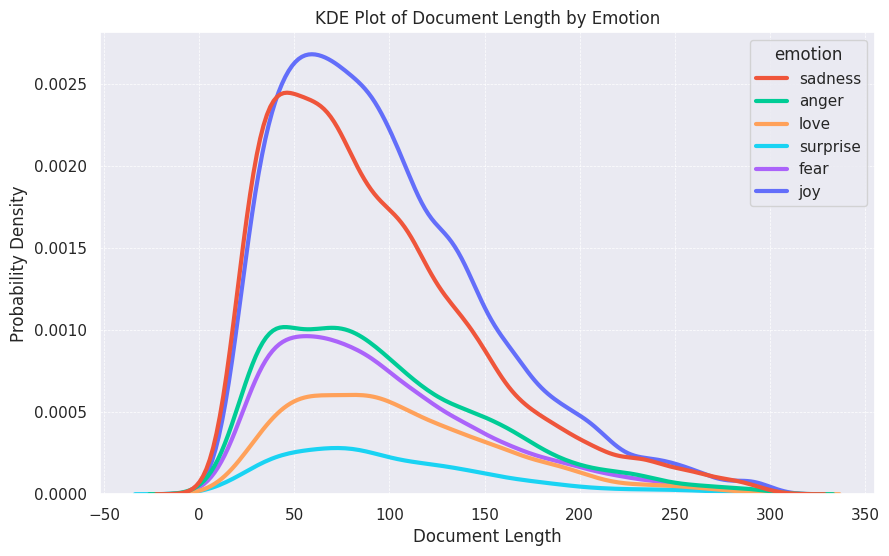

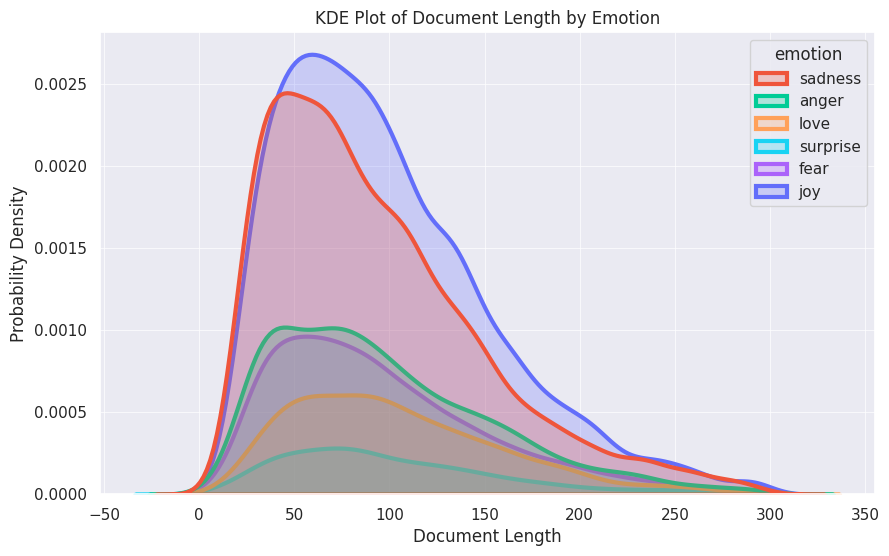

In [18]:
# Create a new column in the combined_df Pandas dataframe called document_length.
#  It is using the apply function to apply the built-in Python function len to
# each value in the document column of the dataframe.
# This calculates the length of each document.

combined_df["document_length"] = combined_df["document"].apply(len)

# First KDE plot.

# NOTE: First and Second KDE plots are the same.
#       The only difference is that the second KDE plot has shade.

fig, ax = plt.subplots(figsize=(10, 6))

# Create a KDE plot.
# The x-axis represents the document_length.
# The y-axis represents the probability density.
# The hue parameter is used to color the plot based on the emotion column in the Pandas dataframe.
# The palette parameter is used to specify the colors for the different emotions

sns.kdeplot(
    x=combined_df["document_length"],
    hue=combined_df["emotion"],
    palette=["#ef553b", "#00cc96", "#ffa15a", "#19d3f3", "#ab63fa", "#636efa"],
    linewidth=3,
    ax=ax,
)

# Set title and labels for the KDE plot.

ax.grid(True, linestyle="--", linewidth=0.5)
ax.set_title("KDE Plot of Document Length by Emotion")
ax.set_xlabel("Document Length")
ax.set_ylabel("Probability Density")

# Display the KDE plot.

plt.show()

# Second KDE plot.

# NOTE: First and Second KDE plots are the same.
#       The only difference is that the second KDE plot has shade.

fig, ax = plt.subplots(figsize=(10, 6))

# Create a KDE plot.
# The x-axis represents the document_length.
# The y-axis represents the probability density.
# The hue parameter is used to color the plot based on the emotion column in the Pandas dataframe.
# The palette parameter is used to specify the colors for the different emotions

sns.kdeplot(
    x=combined_df["document_length"],
    hue=combined_df["emotion"],
    palette=["#ef553b", "#00cc96", "#ffa15a", "#19d3f3", "#ab63fa", "#636efa"],
    linewidth=3,
    shade=True,
    ax=ax,
)

# Set title and labels for the KDE plot.

ax.grid(True, linewidth=0.5)
ax.set_title("KDE Plot of Document Length by Emotion")
ax.set_xlabel("Document Length")
ax.set_ylabel("Probability Density")

# Display the KDE plot.

plt.show()

#### 1.3.4.4 Descriptive Statistics For Document Length


In [19]:
# Generate descriptive statistics.

combined_df[["document_length"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
document_length,19948.0,96.700822,55.799681,7.0,53.0,86.0,129.0,300.0


#### 1.3.4.5 Histogram For Document Length Count


In [20]:
# Create the histogram.

fig = px.histogram(combined_df, x="document_length")

# Add title to the histogram.

fig.update_layout(title="Document Length Count")

# Display the histogram.

fig.show()

---

## #2 Select And Engineer Features


### 2.1 Preprocess The Data Using NLTK


In [21]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [22]:
# Cleaner class is responsible for cleaning the documents using its pipeline function.


class Cleaner:
    def __init__(self):
        pass

    # 1. Make a function that makes all text lowercase.

    def make_lowercase(self, input_string):
        input_string = input_string.split()
        input_string = [y.lower() for y in input_string]
        return " ".join(input_string)

    # 2. Make a function that removes all stopwords.

    def remove_stopwords(self, input_string):
        input_string = [i for i in str(input_string).split() if i not in stop_words]
        return " ".join(input_string)

    # 3. Make a function that removes all numbers.

    def remove_numbers(self, input_string):
        input_string = "".join([i for i in input_string if not i.isdigit()])
        return input_string

    # 4. Make a function that removes all punctuation.

    def remove_punctuation(self, input_string):
        input_string = re.sub(
            "[%s]" % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""),
            " ",
            input_string,
        )
        input_string = input_string.replace(
            "؛",
            "",
        )
        input_string = re.sub("\s+", " ", input_string)
        input_string = " ".join(input_string.split())
        return input_string.strip()

    # 5. Make a function that removes all urls.

    def remove_urls(self, input_string):
        url_pattern = re.compile(r"https?://\S+|www\.\S+")
        return url_pattern.sub(r"", input_string)

    # 6. Make a function for lemmatization.

    def lemmatization(self, input_string):
        lemmatizer = WordNetLemmatizer()
        input_string = input_string.split()
        input_string = [lemmatizer.lemmatize(y) for y in input_string]
        return " ".join(input_string)

    # 7. Make a function that breaks words into their stem words.

    def stem_words(self, input_string):
        porter = PorterStemmer()
        words = word_tokenize(input_string)
        valid_words = []

        for word in words:
            stemmed_word = porter.stem(word)
            valid_words.append(stemmed_word)

        input_string = " ".join(valid_words)

        return input_string

    # 8. Make a pipeline function that applies all the text processing functions you just built.

    def pipeline(self, input_string):
        input_string = self.make_lowercase(input_string)  # 1.
        input_string = self.remove_stopwords(input_string)  # 2.
        input_string = self.remove_numbers(input_string)  # 3.
        input_string = self.remove_punctuation(input_string)  # 4.
        input_string = self.remove_urls(input_string)  # 5.
        input_string = self.lemmatization(input_string)  # 6.
        #         input_string = self.stem_words(input_string)         # 7.
        return input_string

In [23]:
# Clean/Normalize the documents.

cleaner = Cleaner()

combined_df["document_clean"] = combined_df["document"]
combined_df["document_clean"] = combined_df["document"].apply(cleaner.pipeline)

In [24]:
#  Print the first original document.

print("ORIGINAL DOCUMENT:\n\n")
combined_df["document"][0]

ORIGINAL DOCUMENT:




0                                                  i didnt feel humiliated
0    im feeling quite sad and sorry for myself but ill snap out of it soon
0              im feeling rather rotten so im not very ambitious right now
Name: document, dtype: object

In [25]:
#  Print the first cleaned document.

print("\nCLEANED DOCUMENT:\n\n")
combined_df["document_clean"][0]


CLEANED DOCUMENT:




0                          didnt feel humiliated
0       im feeling quite sad sorry ill snap soon
0    im feeling rather rotten im ambitious right
Name: document_clean, dtype: object

In [26]:
# Print the combined_df Pandas dataframe with the clean documents.

combined_df

,document,emotion,document_length,document_clean
0,i didnt feel humiliated,sadness,23,didnt feel humiliated
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,sadness,108,go feeling hopeless damned hopeful around someone care awake
2,im grabbing a minute to post i feel greedy wrong,anger,48,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,love,92,ever feeling nostalgic fireplace know still property
4,i am feeling grouchy,anger,20,feeling grouchy
...,...,...,...,...
1995,i just keep feeling like someone is being unkind to me and doing me wrong and then all i can think of doing is to get back at them and the people they are close to,anger,163,keep feeling like someone unkind wrong think get back people close
1996,im feeling a little cranky negative after this doctors appointment,anger,66,im feeling little cranky negative doctor appointment
1997,i feel that i am useful to my people and that gives me a great feeling of achievement,joy,85,feel useful people give great feeling achievement
1998,im feeling more comfortable with derby i feel as though i can start to step out my shell,joy,88,im feeling comfortable derby feel though start step shell


### 2.2 Define X And y


In [27]:
# X is our feature (document).

X = combined_df["document_clean"]

X

0                                                    didnt feel humiliated
1             go feeling hopeless damned hopeful around someone care awake
2                                im grabbing minute post feel greedy wrong
3                     ever feeling nostalgic fireplace know still property
4                                                          feeling grouchy
                                       ...                                
1995    keep feeling like someone unkind wrong think get back people close
1996                  im feeling little cranky negative doctor appointment
1997                     feel useful people give great feeling achievement
1998             im feeling comfortable derby feel though start step shell
1999              feel weird meet w people text like dont talk face face w
Name: document_clean, Length: 19948, dtype: object

In [28]:
# y is our label. What we want to predict.

y = combined_df["emotion"]

print("y.value_counts() =\n")
print(y.value_counts())

y.value_counts() =

emotion
joy         6739
sadness     5793
anger       2703
fear        2369
love        1630
surprise     714
Name: count, dtype: int64


In [29]:
y

0       sadness
1       sadness
2         anger
3          love
4         anger
         ...   
1995      anger
1996      anger
1997        joy
1998        joy
1999       fear
Name: emotion, Length: 19948, dtype: object

### 2.3 Split Data (train_test_split)

- Train = 80%
- Validation = 10%
- Test = 10%


In [30]:
# Train test split twice to get the train, validation, and test data.

X_train, X_remain, y_train, y_remain = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_remain, y_remain, test_size=0.5, random_state=42
)


print("X_train.shape  = ", X_train.shape)  # 1 Dimension.
print("X_valid.shape  = ", X_valid.shape)  # 1 Dimension.
print("X_test.shape   = ", X_test.shape)  # 1 Dimension.

print()

print("y_train.shape  = ", y_train.shape)  # 1 Dimension.
print("y_valid.shape  = ", y_valid.shape)  # 1 Dimension.
print("y_test.shape   = ", y_test.shape)  # 1 Dimension.

X_train.shape  =  (15958,)
X_valid.shape  =  (1995,)
X_test.shape   =  (1995,)

y_train.shape  =  (15958,)
y_valid.shape  =  (1995,)
y_test.shape   =  (1995,)


### 2.4 Label Encoder


In [31]:
# Create an instance of the LabelEncoder class.

label = LabelEncoder()

# Print the original y_train values.

print(y_train)
print("*" * 100)

# Fit the LabelEncoder on the y_train data and transform it.

y_train = label.fit_transform(y_train)

# Print the transformed y_train values.

print(y_train)
print("*" * 100)

# Transform the y_test and y_valid data using the fitted LabelEncoder.

y_test = label.transform(y_test)
y_valid = label.transform(y_valid)

# Print the classes that the LabelEncoder has learned.

print("label.classes_ =", label.classes_)

14962     sadness
76            joy
1707      sadness
254         anger
940           joy
           ...   
11297        fear
11980       anger
5391          joy
860       sadness
15825    surprise
Name: emotion, Length: 15958, dtype: object
****************************************************************************************************
[4 2 4 ... 2 4 5]
****************************************************************************************************
label.classes_ = ['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']


In [32]:
# Print the original y_train values.

print(y_train)
print("*" * 100)

# Convert y_train into a binary matrix representation.

y_train = to_categorical(y_train)

# Print the transformed y_train values.

print(y_train)
print("*" * 100)

# Convert y_test and y_valid into a binary matrix representation.

y_test = to_categorical(y_test)
y_valid = to_categorical(y_valid)

# Print the classes that the LabelEncoder has learned.

print("label.classes_ =", label.classes_)

[4 2 4 ... 2 4 5]
****************************************************************************************************
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
****************************************************************************************************
label.classes_ = ['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']


### 2.5 Tokenize


In [33]:
# Create an instance of the Tokenizer class.

tokenizer = Tokenizer()

# Fit the Tokenizer on the combined X_train and X_test data.

tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

In [34]:
# Convert X_train, X_test, and X_valid into sequences of integers so that they can
# be input in the model.

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_valid = tokenizer.texts_to_sequences(X_valid)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [35]:
# Pad the sequences to ensure they all have the same length.

X_train = pad_sequences(sequences_train, maxlen=256, truncating="pre")
X_valid = pad_sequences(sequences_valid, maxlen=256, truncating="pre")
X_test = pad_sequences(sequences_test, maxlen=256, truncating="pre")

In [36]:
# Get the size of the vocabulary.

vocabulary_size = len(tokenizer.index_word) + 1
print("vocabulary_size =", vocabulary_size)

vocabulary_size = 14326


---

## #3 Build And Train LSTM Model


In [37]:
# LSTM Model Hyperparameters.

# Embedding.
input_dim = vocabulary_size
output_dim = 200

# Convolution.

kernel_size = 5
filters = 128
pool_size = 4

# LSTM.

lstm_output_size = 128

In [38]:
# Create the neural network.

model = Sequential()

# X_train.shape[1] = 256
model.add(Embedding(input_dim, output_dim, input_length=X_train.shape[1]))

model.add(Dropout(0.25))

model.add(Conv1D(filters, kernel_size, padding="valid", activation="relu", strides=1))

model.add(MaxPooling1D(pool_size=pool_size))

model.add(LSTM(lstm_output_size))

model.add(Dense(6))

model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          2865200   
                                                                 
 dropout (Dropout)           (None, 256, 200)          0         
                                                                 
 conv1d (Conv1D)             (None, 252, 128)          128128    
                                                                 
 max_pooling1d (MaxPooling1  (None, 63, 128)           0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                        

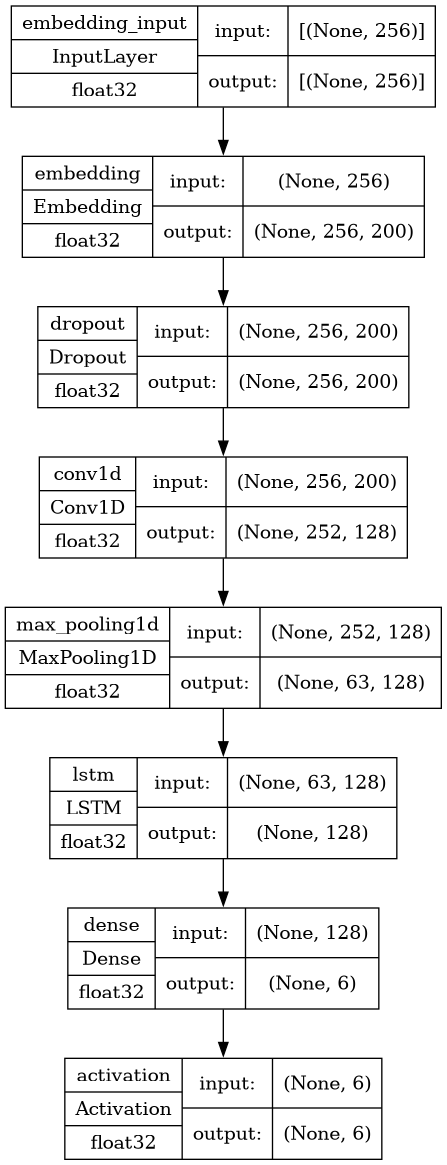

In [39]:
plot_model(model, to_file="tessa_lstm_model.png", show_shapes=True, show_dtype=True)

In [40]:
# Define the optimizer.

adam = Adam(learning_rate=0.0002)

# Define the loss function and metrics.
# Compile the model.

model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

In [41]:
# Define the EarlyStopping callback function.
# Stop the training process if there is no improvement in the validation accuracy for 10 epochs,
# and it will restore the model weights from the epoch with the best validation accuracy.

early_stopping = EarlyStopping(
    monitor="val_accuracy", patience=10, mode="auto", restore_best_weights=True
)

In [42]:
# Define the ReduceLROnPlateau callback function.
# Dynamically reduce the learning rate during the training by a factor of 0.5,
# if there is no improvement in the validation accuracy, with a minimum
# learning rate of 0.00001, and it will print a message for each update

reduce_learning_rate = ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.5, verbose=1, min_lr=0.00001
)

In [43]:
# Fit the model.

history_callback_object = model.fit(
    x=X_train,
    y=y_train,
    batch_size=256,
    epochs=100,
    callbacks=[early_stopping, reduce_learning_rate],
    validation_data=(X_valid, y_valid),
)

Epoch 1/100
63/63 [==============================] - 17s 207ms/step - loss: 1.6086 - accuracy: 0.3285 - val_loss: 1.5647 - val_accuracy: 0.3509 - lr: 2.0000e-04
Epoch 2/100
63/63 [==============================] - 9s 142ms/step - loss: 1.5679 - accuracy: 0.3411 - val_loss: 1.5593 - val_accuracy: 0.3519 - lr: 2.0000e-04
Epoch 3/100
63/63 [==============================] - 7s 108ms/step - loss: 1.5333 - accuracy: 0.4155 - val_loss: 1.4638 - val_accuracy: 0.5053 - lr: 2.0000e-04
Epoch 4/100
63/63 [==============================] - 6s 87ms/step - loss: 1.1965 - accuracy: 0.5907 - val_loss: 0.9398 - val_accuracy: 0.6476 - lr: 2.0000e-04
Epoch 5/100
63/63 [==============================] - 4s 63ms/step - loss: 0.7396 - accuracy: 0.7381 - val_loss: 0.6676 - val_accuracy: 0.7850 - lr: 2.0000e-04
Epoch 6/100
63/63 [==============================] - 4s 66ms/step - loss: 0.5207 - accuracy: 0.8286 - val_loss: 0.5364 - val_accuracy: 0.8276 - lr: 2.0000e-04
Epoch 7/100
63/63 [=======================

In [44]:
# Loss graph.

fig = px.line(
    data_frame=history_callback_object.history,
    y=["loss", "val_loss"],
    labels={"index": "Epoch", "value": "Loss"},
    title="Loss vs Epoch",
)
fig.show()

history_callback_object.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [45]:
# Accuracy graph.

fig = px.line(
    data_frame=history_callback_object.history,
    y=["accuracy", "val_accuracy"],
    labels={"index": "Epoch", "value": "Accuracy"},
    title="Accuracy vs Epoch",
)
fig.show()

history_callback_object.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

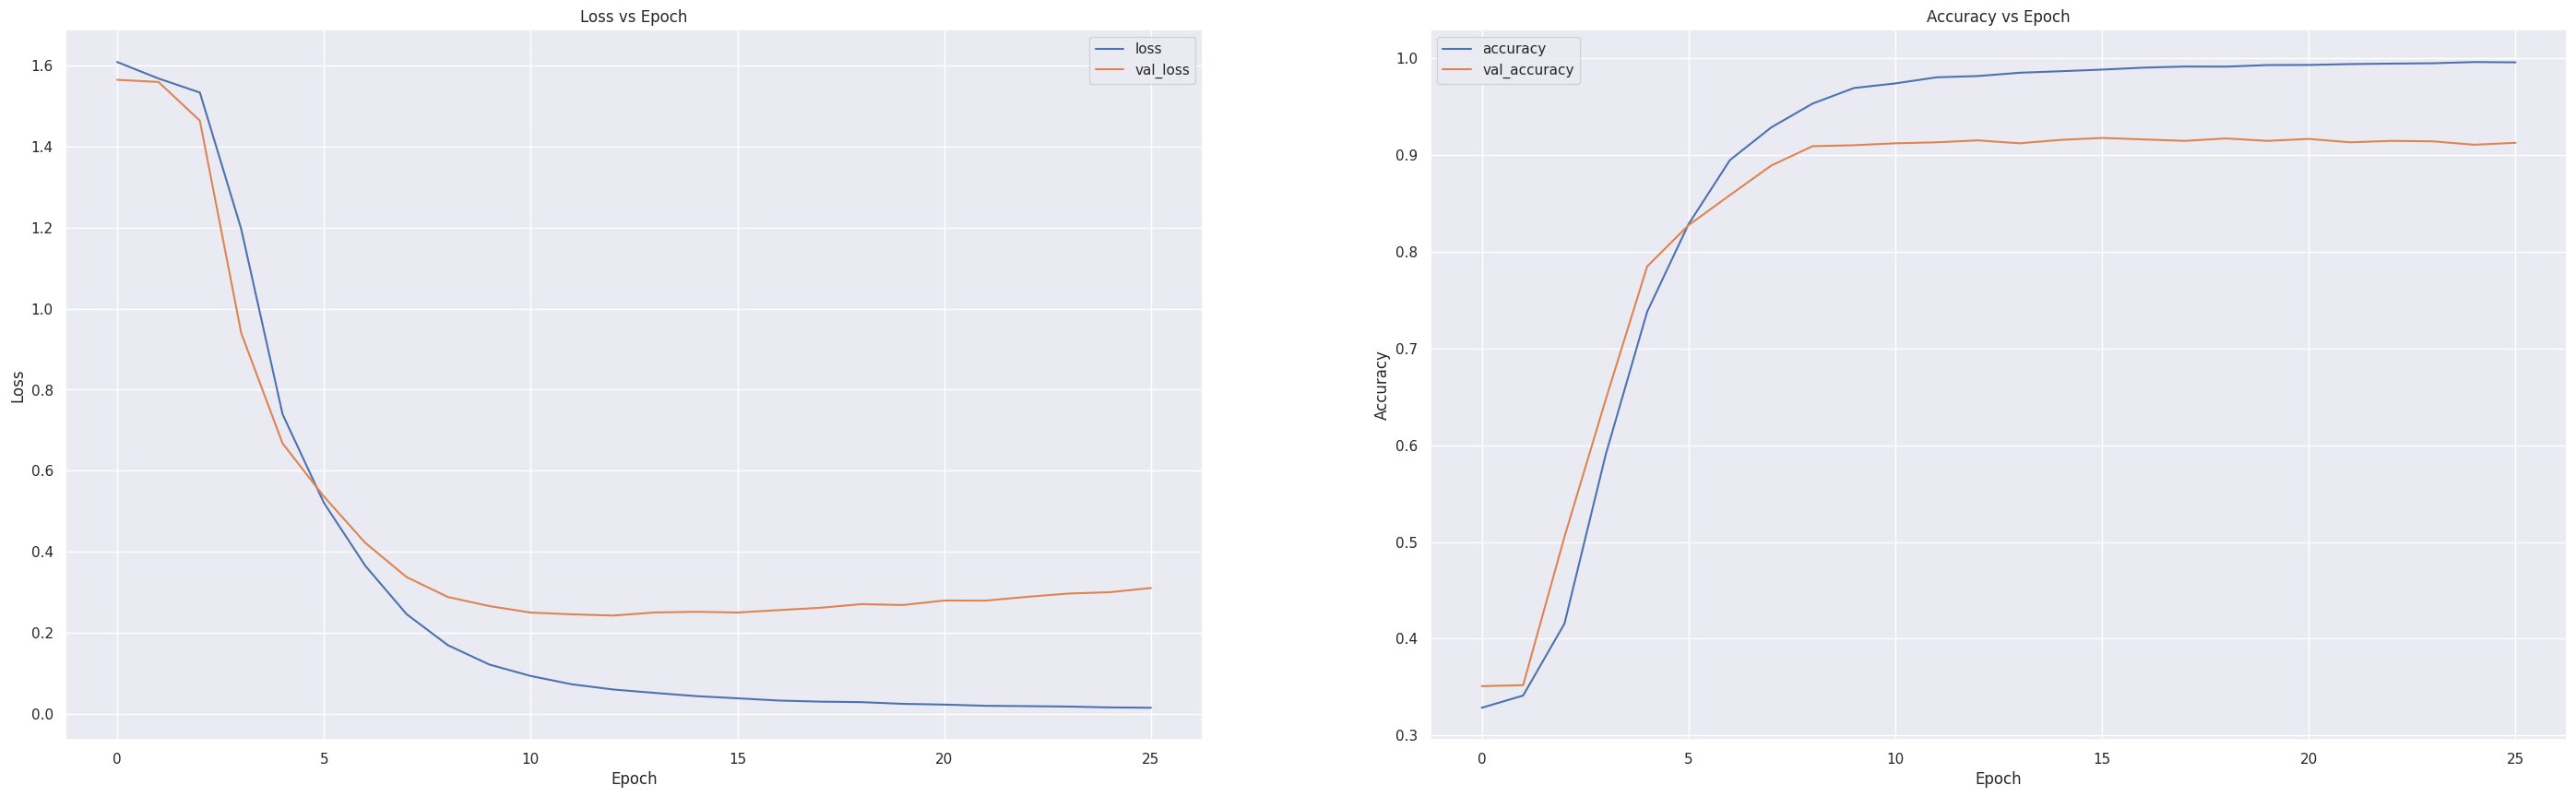

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [46]:
# Both loss and accuracy graphs side to side.

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history_callback_object.history["loss"], label="loss")
ax1.plot(history_callback_object.history["val_loss"], label="val_loss")
ax1.legend()
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss vs Epoch")
ax1.grid(True)

ax2.plot(history_callback_object.history["accuracy"], label="accuracy")
ax2.plot(history_callback_object.history["val_accuracy"], label="val_accuracy")
ax2.legend()
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy vs Epoch")
ax2.grid(True)

fig.set_figheight(10)
fig.set_figwidth(35)
plt.show()

history_callback_object.history.keys()

---

## #4 Evaluate LSTM Model


In [47]:
# y_pred stores the probabilities for each emotion. The highest probability corresponds to the predicted emotion.

y_pred = model.predict(X_test)
print(y_pred[0])
y_pred

63/63 [==============================] - 1s 3ms/step
[2.9925118e-07 1.2080519e-06 9.9951720e-01 2.6102384e-04 1.9178046e-07
 2.1995553e-04]


array([[2.9925118e-07, 1.2080519e-06, 9.9951720e-01, 2.6102384e-04,
        1.9178046e-07, 2.1995553e-04],
       [4.5247825e-06, 3.4138258e-05, 9.9910164e-01, 6.3789100e-04,
        6.5207183e-05, 1.5653971e-04],
       [6.4914749e-04, 6.9027400e-04, 1.1684682e-05, 3.5371356e-06,
        9.9864417e-01, 1.1390937e-06],
       ...,
       [9.6498535e-04, 6.4240576e-04, 1.4241083e-04, 1.1326690e-05,
        9.9823523e-01, 3.5331525e-06],
       [1.3005985e-04, 8.9469599e-05, 4.6233407e-01, 5.2246720e-01,
        8.8595343e-06, 1.4970287e-02],
       [1.4072505e-04, 2.6880869e-06, 3.2233565e-05, 9.9941301e-01,
        9.8499140e-07, 4.1026517e-04]], dtype=float32)

In [48]:
#  Predictions on the test data.

y_pred = np.argmax(y_pred, axis=1)
print(y_pred[0])
y_pred

2


array([2, 2, 4, ..., 4, 3, 3])

In [49]:
# Ground truth labels for the testing data.

y_check = np.argmax(y_test, axis=1)
print(y_check[0])
y_check

2


array([2, 2, 4, ..., 4, 3, 3])

In [50]:
print(
    "Accuracy of model on validation data: ",
    model.evaluate(X_valid, y_valid)[1] * 100,
    "%",
    sep="",
)

63/63 [==============================] - 0s 4ms/step - loss: 0.2502 - accuracy: 0.9178
Accuracy of model on validation data: 91.77944660186768%


In [51]:
print(
    "Accuracy of model on testing data: ",
    model.evaluate(X_test, y_test)[1] * 100,
    "%",
    sep="",
)

63/63 [==============================] - 0s 4ms/step - loss: 0.2843 - accuracy: 0.9068
Accuracy of model on testing data: 90.67668914794922%


In [52]:
model_loss, model_accuracy = model.evaluate(X_test, y_test)

print("Model Test Loss: %f" % (model_loss))
print("Model Test Loss: %f" % (model_loss * 100), "%\n", sep="")
print("Model Test Accuracy: %f" % (model_accuracy))
print("Model Test Accuracy: %f" % (model_accuracy * 100), "%", sep="")

63/63 [==============================] - 0s 4ms/step - loss: 0.2843 - accuracy: 0.9068
Model Test Loss: 0.284312
Model Test Loss: 28.431186%

Model Test Accuracy: 0.906767
Model Test Accuracy: 90.676689%


In [53]:
# Calculate our accuracy score.

accuracy = accuracy_score(y_check, y_pred)

# Calculate our precision score.

precision = precision_score(y_check, y_pred, average="micro")

# Calculate our recall score.

recall = recall_score(y_check, y_pred, average="micro")

# Calculate our f1-score.

f1 = f1_score(y_check, y_pred, average="micro")

# Print each of our scores to inspect performance.

print("Accuracy Score: %f" % (accuracy * 100), "%", sep="")
print("Precision Score: %f" % (precision * 100), "%", sep="")
print("Recall Score: %f" % (recall * 100), "%", sep="")
print("F1 Score: %f" % (f1 * 100), "%", sep="")

Accuracy Score: 90.676692%
Precision Score: 90.676692%
Recall Score: 90.676692%
F1 Score: 90.676692%


[[[1675   32]
  [  24  264]]

 [[1752   19]
  [  34  190]]

 [[1284   52]
  [  45  614]]

 [[1769   43]
  [  40  143]]

 [[1392   26]
  [  27  550]]

 [[1917   14]
  [  16   48]]] 



          anger  fear  joy  love  sadness  surprise
anger       264     4    4     4       11         1
fear         11   190    7     0        5        11
joy           2     1  614    34        7         1
love          5     1   31   143        2         1
sadness      12     5    6     4      550         0
surprise      2     8    4     1        1        48 



0=anger, 1=fear, 2=joy, 3=love, 4=sadness, 5=surprise



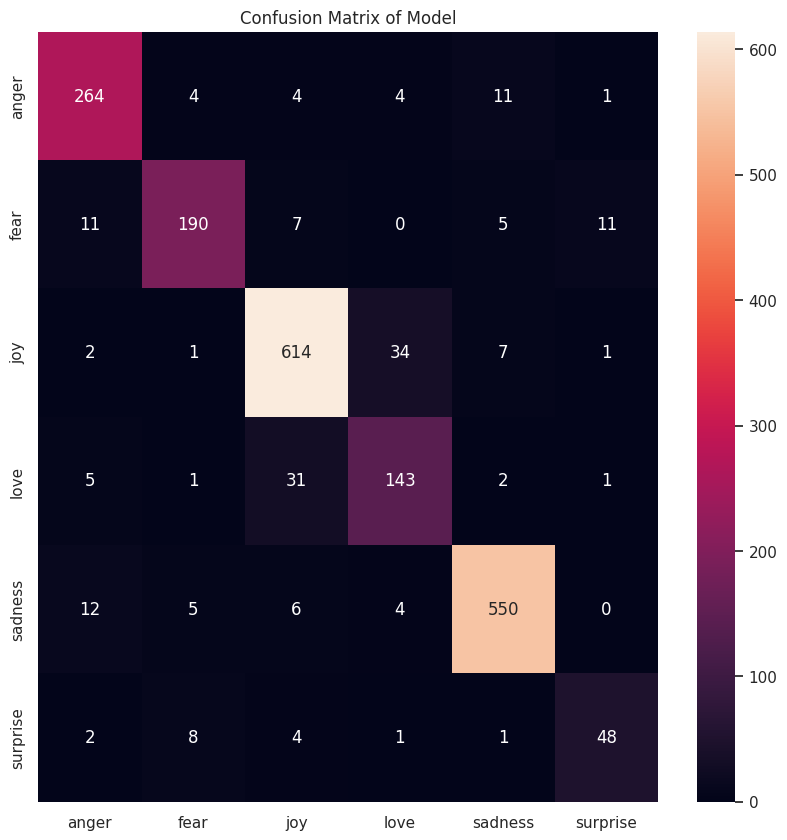

In [54]:
# Confusion Matrix.

emotions_classes_label = ["anger", "fear", "joy", "love", "sadness", "surprise"]

fig = plt.figure(figsize=(10, 10))
plt.title("Confusion Matrix of Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")

cm = multilabel_confusion_matrix(y_check, y_pred)
print(cm, "\n\n\n")

model_matrix = confusion_matrix(y_check, y_pred)
cm = pd.DataFrame(
    model_matrix,
    index=[i for i in emotions_classes_label],
    columns=[i for i in emotions_classes_label],
)


ax = sns.heatmap(cm, annot=True, fmt="d", cbar=True)

print(cm, "\n\n\n")

print("0=anger, 1=fear, 2=joy, 3=love, 4=sadness, 5=surprise\n")

plt.show()

In [55]:
# Classification Report.

y_pred = model.predict(X_test)
y_result = []
y_actual = []

for pred in y_pred:
    y_result.append(np.argmax(pred))

for pred in y_test:
    y_actual.append(np.argmax(pred))

print(
    "Model Classification Report\n",
    classification_report(
        y_actual,
        y_result,
        target_names=["anger", "fear", "joy", "love", "sadness", "surprise"],
    ),
)

63/63 [==============================] - 0s 3ms/step
Model Classification Report
               precision    recall  f1-score   support

       anger       0.89      0.92      0.90       288
        fear       0.91      0.85      0.88       224
         joy       0.92      0.93      0.93       659
        love       0.77      0.78      0.78       183
     sadness       0.95      0.95      0.95       577
    surprise       0.77      0.75      0.76        64

    accuracy                           0.91      1995
   macro avg       0.87      0.86      0.87      1995
weighted avg       0.91      0.91      0.91      1995



In [56]:
tokenizer_file_path = "./tokenizer.pickle"
label_encoder_file_path = "./label_encoder.h5"
model_file_path = "./lstm_model.h5"
model_architecture_file_path = "./lstm_model.json"
model_weights_file_path = "model_weights.h5"

#  Save the tokenizer for inference.

with open(tokenizer_file_path, "wb") as f:
    pickle.dump(tokenizer, f)

#  Save the label encoder for inference.

with open(label_encoder_file_path, "wb") as f:
    pickle.dump(label, f)

#  Save the model for inference.

model.save(model_file_path)


# Save teh model architecture to JSON.

model_json = model.to_json()
with open(model_architecture_file_path, "w") as json_file:
    json_file.write(model_json)

# Save the model weights to HDF5.

model.save_weights(model_weights_file_path)

In [57]:
# Inference function for new user input.


def inference(user_input):
    # Print the user input.

    print("user_input =", user_input)

    # Create an instance of the Cleaner class.

    cleaner = Cleaner()

    # Call the pipeline function on the new user input.

    cleaned_user_input = cleaner.pipeline(user_input)

    # Print the cleaned user input.

    print("cleaned_user_input =", cleaned_user_input)

    # Convert cleaned_user_input into a sequence of integers.

    cleaned_user_input = tokenizer.texts_to_sequences([cleaned_user_input])

    # Pad the sequences to a length of 256.

    cleaned_user_input = pad_sequences(cleaned_user_input, maxlen=256, truncating="pre")

    # Model predicts the predicted emotion for the cleaned_user_input.

    output = label.inverse_transform(
        np.argmax(model.predict(cleaned_user_input), axis=-1)
    )[0]

    # Calculate the probability of the predicted result.

    probability = np.max(model.predict(cleaned_user_input))

    # Print the predicted emotion with its probability.

    print("Predicted Emotion:", output)
    print("With Probability:", probability)

In [58]:
# New user input inference.

inference(
    "It only took one look for me to know we belong together. I'm so happy you're mine, sweetheart."
)

user_input = It only took one look for me to know we belong together. I'm so happy you're mine, sweetheart.
cleaned_user_input = took one look know belong together i m happy mine sweetheart
1/1 [==============================] - 0s 19ms/step
Predicted Emotion: joy
With Probability: 0.9930555
